# Optimise_Task 2

In [ ]:
#!pip install numpy pandas matplotlib seaborn scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import geopandas as gpd
import folium
import osmnx as ox
from shapely.geometry import Point

In [3]:
df = pd.read_csv(r'D:\BIG_DATA\external_data\optimise_task2.csv')

In [4]:
df.head()

,Unnamed: 0,gpsLat,gpsLong,type,physicalPosition,session.averagePower,session.creationTime,session.creationTime.1,session.type,session.position,carChargeParameter.maxPower,carChargeParameter.current,numberStacks,chargerId
0,0,43.075102,13.842823,CCS2_400,4.0,NaN,2024-07-14T06:01:27.461303+00:00,2024-07-14T06:01:27.461303+00:00,NaN,2,0.0,500.0,4.0,13418.0
1,1,44.518340,11.214320,CCS2_400,4.0,NaN,2024-07-14T06:01:29.119003+00:00,2024-07-14T06:01:29.119003+00:00,NaN,2,0.0,200.0,4.0,8118.0
2,2,41.891882,12.758657,CCS2_400,1.0,NaN,2024-07-14T06:01:58.304994+00:00,2024-07-14T06:01:58.304994+00:00,NaN,1,0.0,500.0,4.0,13448.0
3,3,46.206436,13.048325,CCS2_400,1.0,NaN,2024-07-14T06:03:00.278437+00:00,2024-07-14T06:03:00.278437+00:00,NaN,1,0.0,500.0,4.0,19528.0
4,4,45.729300,9.029120,CCS2_400,4.0,NaN,2024-07-14T06:03:25.545657+00:00,2024-07-14T06:03:25.545657+00:00,NaN,2,129000.0,300.0,4.0,9839.0


In [5]:
# Drop the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Check for missing values
print(df.isnull().sum())

gpsLat                           464
gpsLong                          464
type                               0
physicalPosition                  35
session.averagePower           13442
session.creationTime               0
session.creationTime.1             0
session.type                   13442
session.position                   0
carChargeParameter.maxPower       80
carChargeParameter.current        80
numberStacks                    1231
chargerId                       1231
dtype: int64


In [7]:
# Drop columns where all values are NaN
df.dropna(axis=1, how='all', inplace=True)

In [8]:
# Check for missing values
print(df.isnull().sum())

gpsLat                          464
gpsLong                         464
type                              0
physicalPosition                 35
session.creationTime              0
session.creationTime.1            0
session.position                  0
carChargeParameter.maxPower      80
carChargeParameter.current       80
numberStacks                   1231
chargerId                      1231
dtype: int64


In [9]:
# Drop rows where either 'gpsLat' or 'gpsLong' is NaN
df.dropna(subset=['gpsLat', 'gpsLong'], inplace=True)

In [10]:
# Check for missing values
print(df.isnull().sum())

gpsLat                           0
gpsLong                          0
type                             0
physicalPosition                35
session.creationTime             0
session.creationTime.1           0
session.position                 0
carChargeParameter.maxPower     76
carChargeParameter.current      76
numberStacks                   767
chargerId                      767
dtype: int64


In [11]:
# Drop rows where 'carChargeParameter.current' is NaN
df.dropna(subset=['carChargeParameter.current'], inplace=True)

In [12]:
# Check for missing values
print(df.isnull().sum())

gpsLat                           0
gpsLong                          0
type                             0
physicalPosition                35
session.creationTime             0
session.creationTime.1           0
session.position                 0
carChargeParameter.maxPower      0
carChargeParameter.current       0
numberStacks                   760
chargerId                      760
dtype: int64


In [13]:
# Drop rows where 'physicalPosition' is NaN
df.dropna(subset=['physicalPosition'], inplace=True)

In [14]:
# Drop rows where either 'numberStacks' or 'chargerId' is NaN
df.dropna(subset=['numberStacks', 'chargerId'], inplace=True)

In [15]:
# Check for missing values
print(df.isnull().sum())

gpsLat                         0
gpsLong                        0
type                           0
physicalPosition               0
session.creationTime           0
session.creationTime.1         0
session.position               0
carChargeParameter.maxPower    0
carChargeParameter.current     0
numberStacks                   0
chargerId                      0
dtype: int64


In [16]:
df = df.drop('session.creationTime.1', axis=1)

In [17]:
# Ensure 'session.creationTime' is a datetime type
df['session.creationTime'] = pd.to_datetime(df['session.creationTime'])

In [18]:
# Extract the month from the 'session.creationTime'
df['month'] = df['session.creationTime'].dt.month

# Calculate the average current per month over all years
monthly_average = df.groupby(['chargerId', 'month'])['carChargeParameter.current'].mean().reset_index()
monthly_average.rename(columns={'carChargeParameter.current': 'average_current_per_month'}, inplace=True)

# Aggregate charger data
charger_data = df.groupby('chargerId').agg({
    'gpsLat': 'first',  # Assuming latitude doesn't change
    'gpsLong': 'first',  # Assuming longitude doesn't change
    'type': 'first',  # Assuming type doesn't change
    'physicalPosition': 'first',  # Assuming physical position doesn't change
    'session.position': 'first',  # Assuming session position is constant; adjust if needed
    'carChargeParameter.maxPower': 'first',  # Assuming max power doesn't change
    'numberStacks': 'first'  # Assuming number of stacks doesn't change
}).reset_index()

In [19]:
# Merge the average current data with the charger data
final_dataset = pd.merge(charger_data, monthly_average, on='chargerId', how='left')

In [20]:
final_dataset.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,month,average_current_per_month
0,6590.0,44.66229,10.85797,CCS2_400,1.0,1,130000.0,4.0,7,479.057143
1,6590.0,44.66229,10.85797,CCS2_400,1.0,1,130000.0,4.0,8,449.693878
2,6708.0,42.49927,12.31106,CCS2_400,1.0,1,326000.0,4.0,7,429.750000
3,6708.0,42.49927,12.31106,CCS2_400,1.0,1,326000.0,4.0,8,409.259259
4,6709.0,44.66229,10.85801,CCS2_400,1.0,1,326000.0,4.0,7,435.372549


In [21]:
# Calculate the average current per charger across all months
average_current = final_dataset.groupby('chargerId')['average_current_per_month'].mean().reset_index()
average_current.rename(columns={'average_current_per_month': 'average_current_all_months'}, inplace=True)

# Aggregate charger data
charger_data = final_dataset[['chargerId', 'gpsLat', 'gpsLong', 'type', 'physicalPosition', 
                   'session.position', 'carChargeParameter.maxPower', 'numberStacks']].drop_duplicates()

# Merge the average current data with the charger data
final_dataset = pd.merge(charger_data, average_current, on='chargerId', how='left')

In [22]:
# Output the final dataset
final_dataset.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547


In [23]:
final_dataset.describe()

,chargerId,gpsLat,gpsLong,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,20667.908676,43.762222,11.654207,2.383562,1.461187,112775.068493,3.972603,447.280451
std,20253.174315,1.601791,2.183586,1.498900,0.499633,125837.364065,0.233006,59.855966
min,6590.000000,40.837697,8.441120,1.000000,1.000000,0.000000,1.000000,0.000000
25%,9919.500000,42.202297,9.393790,1.000000,1.000000,0.000000,4.000000,424.291074
50%,16938.000000,44.392329,11.570790,1.000000,1.000000,50000.000000,4.000000,446.653857
75%,19527.500000,45.074655,13.258022,4.000000,2.000000,250000.000000,4.000000,470.086953
max,83836.000000,46.499058,16.777855,4.000000,2.000000,337000.000000,4.000000,799.000000


In [24]:
final_dataset.dtypes

chargerId                      float64
gpsLat                         float64
gpsLong                        float64
type                            object
physicalPosition               float64
session.position                 int64
carChargeParameter.maxPower    float64
numberStacks                   float64
average_current_all_months     float64
dtype: object

## Define grids

<Axes: >

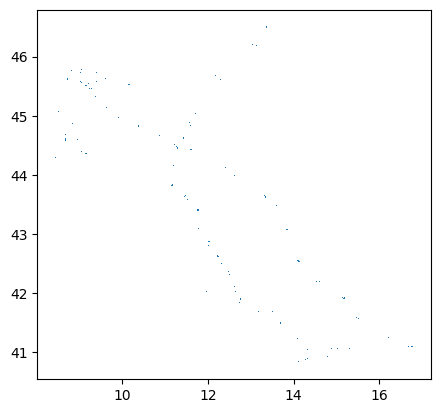

In [25]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def create_1km_grid(lat, lon):
    # Approximate km per degree
    km_in_degree = 1 / 110.574
    km_lon = 1 / (111.320 * np.cos(np.radians(lat)))
    
    # Define the square grid, approx 1km by 1km
    square = Polygon([
        (lon - km_lon, lat - km_in_degree),
        (lon - km_lon, lat + km_in_degree),
        (lon + km_lon, lat + km_in_degree),
        (lon + km_lon, lat - km_in_degree)
    ])
    return square

# Ensure correct DataFrame name and structure in zipping
gdf = gpd.GeoDataFrame(
    final_dataset,
    geometry=[create_1km_grid(lat, lon) for lat, lon in zip(final_dataset['gpsLat'], final_dataset['gpsLong'])],
    crs="EPSG:4326"  # Ensure it's in latitude and longitude
)

# visualize the grid
gdf.plot()

In [26]:
import geopandas as gpd
from shapely.geometry import Polygon

def create_1km_grid(lat, lon):
    """Creates a 1km x 1km square grid around a given point (latitude, longitude)."""
    # Approximate metrics for 1km at given latitude; adjust as necessary
    km_lat = 1 / 110.574  # degrees latitude per kilometer
    km_lon = 1 / (111.320 * np.cos(np.radians(lat)))  # degrees longitude per kilometer

    # Define the bounds of the square grid
    lat_min = lat - (km_lat / 2)
    lat_max = lat + (km_lat / 2)
    lon_min = lon - (km_lon / 2)
    lon_max = lon + (km_lon / 2)

    # Create a polygon
    square = Polygon([
        (lon_min, lat_min),
        (lon_min, lat_max),
        (lon_max, lat_max),
        (lon_max, lat_min),
        (lon_min, lat_min)
    ])
    return square

# Apply the function to each row in your DataFrame
final_dataset['polygon'] = final_dataset.apply(lambda x: create_1km_grid(x['gpsLat'], x['gpsLong']), axis=1)

# Convert final_dataset to a GeoDataFrame
gdf = gpd.GeoDataFrame(final_dataset, geometry='polygon', crs="EPSG:4326")

In [27]:
gdf.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months,polygon
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510,"POLYGON ((10.85166 44.65777, 10.85166 44.66681..."
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630,"POLYGON ((12.30497 42.49475, 12.30497 42.50379..."
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484,"POLYGON ((10.85170 44.65777, 10.85170 44.66681..."
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078,"POLYGON ((12.30498 42.49477, 12.30498 42.50381..."
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ..."


In [28]:
import geopandas as gpd
import osmnx as ox

# Fetch charging stations across Italy from OSM
charging_stations = ox.geometries_from_place('Italy', tags={'amenity': 'charging_station'})

# Ensure the CRS matches that of 'gdf'
charging_stations = charging_stations.to_crs(gdf.crs)

# Perform a spatial join to find charging stations within each grid
joined_data = gpd.sjoin(gdf, charging_stations, how='left', op='contains')

# Count the number of charging stations in each grid
gdf['number_charging_station'] = joined_data.groupby(joined_data.index).size()

# Fill NaN values with 0 for grids without any charging stations
gdf['number_charging_station'].fillna(0, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\1403554241.py:5: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  charging_stations = ox.geometries_from_place('Italy', tags={'amenity': 'charging_station'})
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\osmnx\_overpass.py:254: UserWarning: This area is 344 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.

In [29]:
gdf.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months,polygon,number_charging_station
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",1
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",1
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",1
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",1
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",1


In [30]:
# Load the population data
df_pop = pd.read_csv("D:/charging_stations/task2/dataset/ita_general_2020.csv")

In [31]:
from shapely.geometry import Point

# Convert to GeoDataFrame with point geometry
df_pop = gpd.GeoDataFrame(
    df_pop,
    geometry=gpd.points_from_xy(df_pop.longitude, df_pop.latitude),
    crs="EPSG:4326"  # Set CRS to WGS 84
)

# Check CRS of the main GeoDataFrame and convert if necessary
if df_pop.crs != gdf.crs:
    df_pop = df_pop.to_crs(gdf.crs)

# Perform a spatial join
joined = gpd.sjoin(gdf, df_pop, how='left', op='contains')

# Aggregate population data
population_density = joined.groupby('polygon')['ita_general_2020'].sum().reset_index()
population_density.rename(columns={'ita_general_2020': 'total_population'}, inplace=True)

# Calculate the area for each polygon in square kilometers
gdf['area_km2'] = 1

# Merge area data to calculate density
population_density = population_density.merge(gdf[['polygon', 'area_km2']], on='polygon')
population_density['population_density'] = population_density['total_population'] / population_density['area_km2']

# Merge back to the original GeoDataFrame
gdf = gdf.merge(population_density[['polygon', 'population_density']], on='polygon', how='left')

C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [33]:
gdf.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months,polygon,number_charging_station,area_km2,population_density
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",1,1,52.367585
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",1,1,26.962282
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",1,1,52.452599
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",1,1,26.962282
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",1,1,9.684774


In [35]:
features = {
    'amenity': ['school', 'university', 'restaurant', 'place_of_worship', 
                'community_centre', 'townhall', 'parking', 'library'],
    'leisure': ['park', 'cinema'],
    'building': ['commercial', 'government', 'civic', 'retail']
}

In [37]:
import osmnx as ox
import geopandas as gpd

# Assuming 'gdf' is your GeoDataFrame with polygons
for feature_type, values in features.items():
    # Column for storing POI counts
    for value in values:
        gdf[f'{feature_type}_{value}_count'] = 0  # initialize the count column

    for idx, row in gdf.iterrows():
        polygon = row['polygon']
        poi_count = {}

        for value in values:
            # Query for POIs within the polygon
            tags = {feature_type: value}
            try:
                pois = ox.geometries_from_polygon(polygon, tags)
                poi_count[value] = len(pois)
            except Exception as e:
                print(f"Error querying {value}: {str(e)}")
                poi_count[value] = 0  # Handle areas with no data

        # Update the counts in the dataframe
        for key, count in poi_count.items():
            gdf.loc[idx, f'{feature_type}_{key}_count'] = count

# Ensure all data operations are complete
gdf = gdf.copy()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.
Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.
Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying restaurant: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying parking: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.
Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying place_of_worship: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying townhall: No data elements in server response. Check log and query location/tags.
Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying university: No data elements in server response. Check log and query location/tags.
Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying parking: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying restaurant: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying place_of_worship: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying school: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying university: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying community_centre: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying townhall: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying library: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying park: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.
Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying park: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying cinema: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying commercial: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.
Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying civic: No data elements in server response. Check log and query location/tags.
Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.
Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: Futu

Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying commercial: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying government: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying civic: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2825253377.py:18: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  pois = ox.geometries_from_polygon(polygon, tags)


Error querying retail: No data elements in server response. Check log and query location/tags.


In [38]:
gdf.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months,polygon,...,amenity_community_centre_count,amenity_townhall_count,amenity_parking_count,amenity_library_count,leisure_park_count,leisure_cinema_count,building_commercial_count,building_government_count,building_civic_count,building_retail_count
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",...,0,0,6,0,0,0,1,0,0,2
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",...,0,0,0,0,0,0,0,0,0,0
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",...,0,0,6,0,0,0,1,0,0,2
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",...,0,0,0,0,0,0,0,0,0,0
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",...,0,0,2,0,0,0,0,0,0,1


In [42]:
# Define the land use categories
categories = {
    'residential': ['residential'],
    'commercial': ['commercial', 'retail', 'office', 'industrial'],
    'retail': ['retail'],
    'industrial': ['industrial'],
    'other': ['agricultural', 'forest', 'conservation', 'recreation']
}

# Function to categorize land use
def categorize_landuse(landuse_gdf):
    # Initialize the category as 'Other'
    category = 'Other'
    if not landuse_gdf.empty:
        # Count occurrences of each landuse type
        counts = landuse_gdf['landuse'].value_counts()
        # Find the most frequent landuse category
        for cat, types in categories.items():
            if any(landuse in counts for landuse in types):
                category = cat
                break
    return category

# Create a new column for land use categories
gdf['land_use'] = 'Other'  # Initialize the column with 'Other'

# Iterate over each polygon in gdf to find land use
for idx, row in gdf.iterrows():
    try:
        # Extract land use within the polygon
        landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
        # Categorize land use and update the dataframe
        gdf.at[idx, 'land_use'] = categorize_landuse(landuse_gdf)
    except Exception as e:
        print(f"Failed to fetch or process land use data for index {idx}: {str(e)}")

# Check the resulting DataFrame
gdf[['polygon', 'land_use']].head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 1: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 3: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 13: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 14: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 18: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 19: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 20: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 21: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 22: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 23: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 42: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 74: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 77: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 93: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 94: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 96: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 98: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 102: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 103: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 145: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 149: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})


Failed to fetch or process land use data for index 150: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 156: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 163: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 201: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

Failed to fetch or process land use data for index 217: No data elements in server response. Check log and query location/tags.


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\2124564779.py:31: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  landuse_gdf = ox.geometries_from_polygon(row['polygon'], tags={'landuse': True})
C:\Users

,polygon,land_use
0,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",residential
1,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",Other
2,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",residential
3,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",Other
4,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",Other


In [43]:
# Function to aggregate road data for a given polygon
def aggregate_road_data(polygon):
    # Define the tags for the road data we're interested in
    tags = {'highway': True}
    
    # Attempt to fetch road data within the polygon
    try:
        roads = ox.geometries_from_polygon(polygon, tags)
        if roads.empty:
            return 'No roads', None, None, None  # Return defaults if no roads found
        
        # Process 'oneway' status
        oneway = roads['oneway'].mode().iloc[0] if 'oneway' in roads else None
        
        # Process 'lanes' by finding the most common value
        lanes = roads['lanes'].mode().iloc[0] if 'lanes' in roads else None
        
        # Process 'highway' type
        highway = roads['highway'].mode().iloc[0] if 'highway' in roads else None
        
        # Process 'maxspeed' by converting to numeric and finding the mean
        if 'maxspeed' in roads:
            roads['maxspeed'] = pd.to_numeric(roads['maxspeed'].str.replace(' km/h', '', regex=False), errors='coerce')
            maxspeed = roads['maxspeed'].mean()
        else:
            maxspeed = None
            
        return oneway, lanes, highway, maxspeed

    except Exception as e:
        print(f"Failed to fetch or process road data: {str(e)}")
        return None, None, None, None  # Return None for all values in case of failure

# Initialize new columns
gdf['oneway'] = None
gdf['lanes'] = None
gdf['highway'] = None
gdf['maxspeed'] = None

# Iterate over each polygon to fetch and store road data
for idx, row in gdf.iterrows():
    oneway, lanes, highway, maxspeed = aggregate_road_data(row['polygon'])
    gdf.at[idx, 'oneway'] = oneway
    gdf.at[idx, 'lanes'] = lanes
    gdf.at[idx, 'highway'] = highway
    gdf.at[idx, 'maxspeed'] = maxspeed

# Check the resulting DataFrame
gdf[['polygon', 'oneway', 'lanes', 'highway', 'maxspeed']].head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\4187208166.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  roads = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\4187208166.py:8: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  roads = ox.geometries_from_polygon(polygon, tags)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\4187208166.py:8: Futur

,polygon,oneway,lanes,highway,maxspeed
0,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",yes,4,service,109.230769
1,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",yes,2,service,85.0
2,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",yes,4,service,109.230769
3,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",yes,2,service,85.0
4,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",yes,3,service,130.0


In [44]:
# Function to extract node and edge counts for a given polygon
def extract_network_data(polygon):
    try:
        # Create network from polygon
        G = ox.graph_from_polygon(polygon, network_type='drive', simplify=True)

        # Convert the graph to a GeoDataFrame
        nodes, edges = ox.graph_to_gdfs(G)

        # Count nodes and edges
        node_count = len(nodes)
        edge_count = len(edges)

        return node_count, edge_count

    except Exception as e:
        print(f"Failed to create network or convert to GeoDataFrame: {str(e)}")
        return 0, 0  # Return 0 for node and edge counts in case of failure

# Initialize new columns for node and edge counts
gdf['node_count'] = 0
gdf['edge_count'] = 0

# Iterate over each polygon to fetch and store network data
for idx, row in gdf.iterrows():
    node_count, edge_count = extract_network_data(row['polygon'])
    gdf.at[idx, 'node_count'] = node_count
    gdf.at[idx, 'edge_count'] = edge_count

# Check the resulting DataFrame
gdf[['polygon', 'node_count', 'edge_count']].head()

Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Found no graph nodes within the requested polygon
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Found no graph nodes within the requested polygon
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Failed to create network or convert to GeoDataFrame: Connectivity is undefined for the null graph.
Fa

,polygon,node_count,edge_count
0,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",15,31
1,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",4,8
2,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",15,31
3,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",4,8
4,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",12,24


In [45]:
gdf.head()

,chargerId,gpsLat,gpsLong,type,physicalPosition,session.position,carChargeParameter.maxPower,numberStacks,average_current_all_months,polygon,...,building_government_count,building_civic_count,building_retail_count,land_use,oneway,lanes,highway,maxspeed,node_count,edge_count
0,6590.0,44.662290,10.857970,CCS2_400,1.0,1,130000.0,4.0,464.375510,"POLYGON ((10.85166 44.65777, 10.85166 44.66681...",...,0,0,2,residential,yes,4,service,109.230769,15,31
1,6708.0,42.499270,12.311060,CCS2_400,1.0,1,326000.0,4.0,419.504630,"POLYGON ((12.30497 42.49475, 12.30497 42.50379...",...,0,0,0,Other,yes,2,service,85.0,4,8
2,6709.0,44.662290,10.858010,CCS2_400,1.0,1,326000.0,4.0,459.573484,"POLYGON ((10.85170 44.65777, 10.85170 44.66681...",...,0,0,2,residential,yes,4,service,109.230769,15,31
3,6710.0,42.499290,12.311070,CCS2_400,4.0,2,326000.0,4.0,472.371078,"POLYGON ((12.30498 42.49477, 12.30498 42.50381...",...,0,0,0,Other,yes,2,service,85.0,4,8
4,6724.0,45.321012,9.375258,CCS2_400,1.0,1,129000.0,4.0,395.642547,"POLYGON ((9.36887 45.31649, 9.36887 45.32553, ...",...,0,0,1,Other,yes,3,service,130.0,12,24


In [46]:
gdf.to_csv(r"D:\BIG_DATA\charging_stations\task_2\optimise_task2.csv")

In [134]:
gdf = pd.read_csv(r"D:\BIG_DATA\charging_stations\task_2\optimise_task2.csv")

# Predict Average energy per month

In [135]:
gdf.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,247.0,123.000000,71.446950,0.000000,61.500000,123.000000,184.500000,246.000000
chargerId,247.0,22946.000000,22853.852393,6590.000000,10287.500000,16945.000000,19744.500000,83836.000000
gpsLat,247.0,43.815654,1.583581,40.837697,42.341169,44.427700,45.142614,46.499058
gpsLong,247.0,11.550898,2.164572,8.441120,9.390614,11.569060,13.087349,16.777855
physicalPosition,247.0,2.384615,1.498592,1.000000,1.000000,1.000000,4.000000,4.000000
session.position,247.0,1.461538,0.499531,1.000000,1.000000,1.000000,2.000000,2.000000
carChargeParameter.maxPower,247.0,116266.153846,126508.769927,0.000000,0.000000,100000.000000,250000.000000,337000.000000
numberStacks,247.0,3.975709,0.219518,1.000000,4.000000,4.000000,4.000000,4.000000
average_current_all_months,247.0,447.690158,59.807246,0.000000,422.490942,445.707341,472.302431,799.000000
number_charging_station,247.0,1.396761,0.695857,1.000000,1.000000,1.000000,2.000000,5.000000


In [136]:
# Check for missing values
gdf.isnull().sum()

Unnamed: 0                          0
chargerId                           0
gpsLat                              0
gpsLong                             0
type                                0
physicalPosition                    0
session.position                    0
carChargeParameter.maxPower         0
numberStacks                        0
average_current_all_months          0
polygon                             0
number_charging_station             0
area_km2                            0
population_density                  0
land_use_summary                  246
amenity_school_count                0
amenity_university_count            0
amenity_restaurant_count            0
amenity_place_of_worship_count      0
amenity_community_centre_count      0
amenity_townhall_count              0
amenity_parking_count               0
amenity_library_count               0
leisure_park_count                  0
leisure_cinema_count                0
building_commercial_count           0
building_gov

In [137]:
# Dropping the specified features
gdf = gdf.drop(columns=['land_use_summary', 'gpsLat', 'gpsLong', 'polygon', 'area_km2'])

In [138]:
gdf['oneway'].fillna('No', inplace=True)
gdf['lanes'].fillna(0, inplace=True)
mean_speed = gdf['maxspeed'].mean()
gdf['maxspeed'].fillna(mean_speed, inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\4110023556.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  gdf['oneway'].fillna('No', inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5740\4110023556.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

In [139]:
# Check for missing values
gdf.isnull().sum()

Unnamed: 0                        0
chargerId                         0
type                              0
physicalPosition                  0
session.position                  0
carChargeParameter.maxPower       0
numberStacks                      0
average_current_all_months        0
number_charging_station           0
population_density                0
amenity_school_count              0
amenity_university_count          0
amenity_restaurant_count          0
amenity_place_of_worship_count    0
amenity_community_centre_count    0
amenity_townhall_count            0
amenity_parking_count             0
amenity_library_count             0
leisure_park_count                0
leisure_cinema_count              0
building_commercial_count         0
building_government_count         0
building_civic_count              0
building_retail_count             0
land_use                          0
oneway                            0
lanes                             0
highway                     

In [140]:
gdf.dtypes

Unnamed: 0                          int64
chargerId                         float64
type                               object
physicalPosition                  float64
session.position                    int64
carChargeParameter.maxPower       float64
numberStacks                      float64
average_current_all_months        float64
number_charging_station             int64
population_density                float64
amenity_school_count                int64
amenity_university_count            int64
amenity_restaurant_count            int64
amenity_place_of_worship_count      int64
amenity_community_centre_count      int64
amenity_townhall_count              int64
amenity_parking_count               int64
amenity_library_count               int64
leisure_park_count                  int64
leisure_cinema_count                int64
building_commercial_count           int64
building_government_count           int64
building_civic_count                int64
building_retail_count             

In [141]:
from sklearn.model_selection import train_test_split, cross_val_score

# Splitting the data into train+validation and test sets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    gdf.drop(columns=['average_current_all_months', 'Unnamed: 0', 'chargerId']), 
    gdf['average_current_all_months'], 
    test_size=0.15, 
    random_state=23
)

# Splitting the train+validation into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, 
    Y_train_val, 
    test_size=0.15, 
    random_state=23
)

In [142]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define categorical and numerical features
categorical_features = ['type', 'physicalPosition', 'session.position', 'land_use', 'oneway', 'highway']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Creating a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Fitting the preprocessor on the training data and transforming training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

## Random Forest

In [143]:
# Define the model
random = RandomForestRegressor(n_estimators=100, random_state=42)

# Apply 5-fold cross-validation
cv_scores = cross_val_score(random, X_train_scaled, Y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE for each fold
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-validation RMSE scores:", cv_rmse_scores)
print("Mean RMSE across folds:", np.mean(cv_rmse_scores))
print("Standard deviation of RMSE across folds:", np.std(cv_rmse_scores))

# Train model on the full training set and evaluate on the validation set
random.fit(X_train_scaled, Y_train)
val_predictions = random.predict(X_val_scaled)
val_rmse = np.sqrt(mean_squared_error(Y_val, val_predictions))
print("Validation RMSE:", val_rmse)

# Finally, evaluate on the test set
test_predictions = random.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predictions))
print("Test RMSE:", test_rmse)

Cross-validation RMSE scores: [34.25289313 47.39584136 40.99369039 56.19646217 58.97436848]
Mean RMSE across folds: 47.56265110657736
Standard deviation of RMSE across folds: 9.220615104722802
Validation RMSE: 76.62625526820985
Test RMSE: 46.411364827900165


## Ensembles

In [144]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the GBM
gbm = GradientBoostingRegressor(random_state=42)

# Perform cross-validation
scores = cross_val_score(gbm, X_train_scaled, Y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-scores)
print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Average RMSE: {np.mean(rmse_scores)}")

Cross-validated RMSE scores: [38.39746815 41.67399057 42.06852416 54.94148771 70.11922064]
Average RMSE: 49.440138244334285


In [145]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

# Setup the GridSearchCV
grid_search = GridSearchCV(gbm, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit grid_search to the data
grid_search.fit(X_train_scaled, Y_train)

# Best parameters and RMSE
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best RMSE: 47.96117037805998


In [146]:
# Validate the model
y_val_pred = grid_search.best_estimator_.predict(X_val_scaled)
val_rmse = mean_squared_error(Y_val, y_val_pred, squared=False)
print(f"Validation RMSE: {val_rmse}")

# Test the model
y_test_pred = grid_search.best_estimator_.predict(X_test_scaled)
test_rmse = mean_squared_error(Y_test, y_test_pred, squared=False)
print(f"Test RMSE: {test_rmse}")

Validation RMSE: 74.58942015920614
Test RMSE: 48.01211025225384


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Linear Regression

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline that includes scaling and linear regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the model on the training set
lr_pipeline.fit(X_train_scaled, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [148]:
from sklearn.metrics import mean_squared_error

# Predict on the validation set
y_val_pred = lr_pipeline.predict(X_val_scaled)

# Calculate the RMSE for the validation set
rmse_val = mean_squared_error(Y_val, y_val_pred, squared=False)
print("Validation RMSE:", rmse_val)

Validation RMSE: 129.2955756245608


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [149]:
# Predict on the test set
y_test_pred = lr_pipeline.predict(X_test_scaled)

# Calculate the RMSE for the test set
rmse_test = mean_squared_error(Y_test, y_test_pred, squared=False)
print("Test RMSE:", rmse_test)

Test RMSE: 50.324751444668216


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
